In [1]:
from utils import *
np.random.seed(42)

### Data

In [2]:
# Load the data
data = loadmat("subjects/s2/S2_A1_E1.mat")
emg = data["emg"]
emg_data = data["emg"].copy()
print("EMG data dimension: {}".format(emg_data.shape))

EMG data dimension: (100686, 10)


In [3]:
# Extract data for joints 3, 6, 8, 11, and 14
joints_indices = [2, 5, 7, 10, 13]  # number adjusted
glove_data_index = data["glove"][:, joints_indices]

print("Selected glove data dimension:", glove_data_index.shape)

Selected glove data dimension: (100686, 5)


### Repetitions data

In [4]:
# repetition of the data
repetition = data["repetition"]
print("Repetition data dimension:", repetition.shape)

Repetition data dimension: (100686, 1)


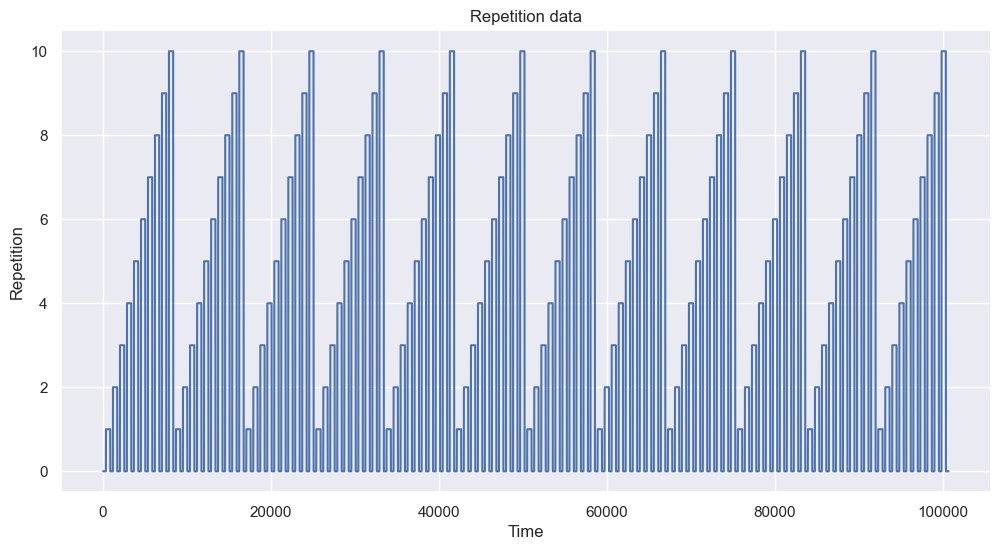

In [5]:
# plot repetition data
plt.figure(figsize=(12, 6))
plt.plot(repetition)
plt.title("Repetition data")
plt.xlabel("Time")
plt.ylabel("Repetition")
plt.show()

In [6]:
# time of first repetition
first_repetition = np.where(repetition[0:5000] == 1)[0][0]
print("Time of first repetition:", first_repetition)
# time of the end od first repetition
end_first_repetition = np.where(repetition[first_repetition:5000] == 0)[0][0]
print("Duration of first repetition:", end_first_repetition)

# time of second repetition
second_repetition = np.where(repetition[0:5000] == 2)[0][0]
print("Time of second repetition:", second_repetition)
# time of the end od second repetition
end_second_repetition = np.where(repetition[second_repetition:5000] == 0)[0][0]
print("Duration of second repetition:", end_second_repetition)

Time of first repetition: 333
Duration of first repetition: 512
Time of second repetition: 1165
Duration of second repetition: 512


## 1. Visualization
Visualize the data and preprocess them accordingly. Use the joint angles 3,6,8,11,14 (refer to picture below). Split the dataset into training, validation and test sets. Take note of how the splitting is done for a time-series data.

### Visualization of all the data

We visualize the data of EMG (in blue) and the angle of the joints (in orange)

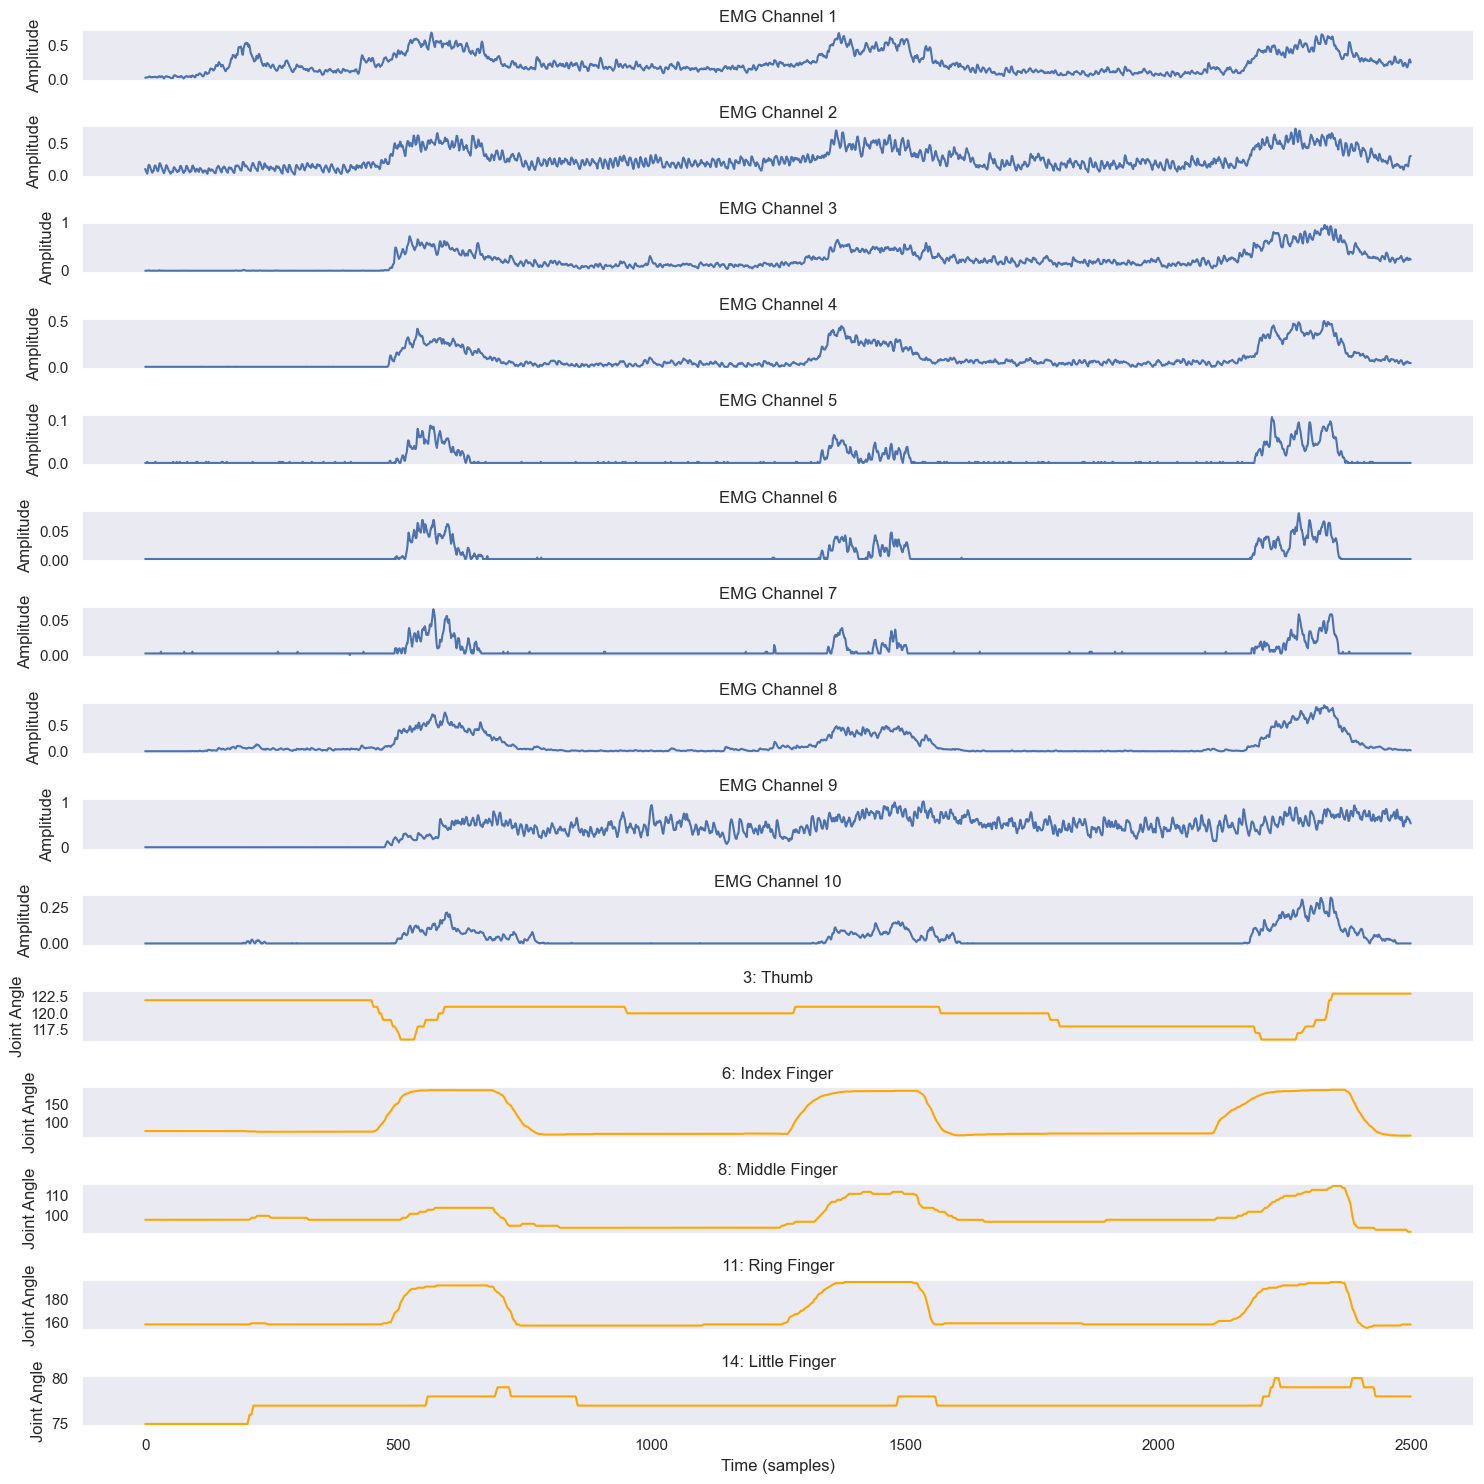

In [7]:
# Updated joint names
joint_names = ["3: Thumb", "6: Index Finger", "8: Middle Finger", "11: Ring Finger", "14: Little Finger"]

# Number of EMG channels
num_emg_channels = emg_data.shape[1]

# Create subplots: EMG channels + Joint angles
fig, axes = plt.subplots(num_emg_channels + len(joint_names), 1, figsize=(15, 15), sharex=True)

# Plot EMG signals
for i in range(num_emg_channels):
    axes[i].plot(emg_data[0:2500, i], label=f"EMG Channel {i+1}")
    axes[i].set_title(f"EMG Channel {i+1}")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid()

# Plot joint angles
for i, joint_name in enumerate(joint_names):
    axes[num_emg_channels + i].plot(glove_data_index[0:2500, i], label=joint_name, color="orange")
    axes[num_emg_channels + i].set_title(joint_name)
    axes[num_emg_channels + i].set_ylabel("Joint Angle")
    axes[num_emg_channels + i].grid()

# Set x-axis label for the last subplot
axes[-1].set_xlabel("Time (samples)")

# Adjust layout
plt.tight_layout()
plt.show()

### Visualization of the data processed by repetitions

In [8]:
# for visualizing the data
train_reps = [1, 2, 3, 4, 7, 8, 9, 10]

# Create masks for train and test based on the repetition column
train_mask = np.isin(repetition, train_reps).flatten()

EMG_data_train = emg_data[train_mask]
Labels_data_train = glove_data_index[train_mask]

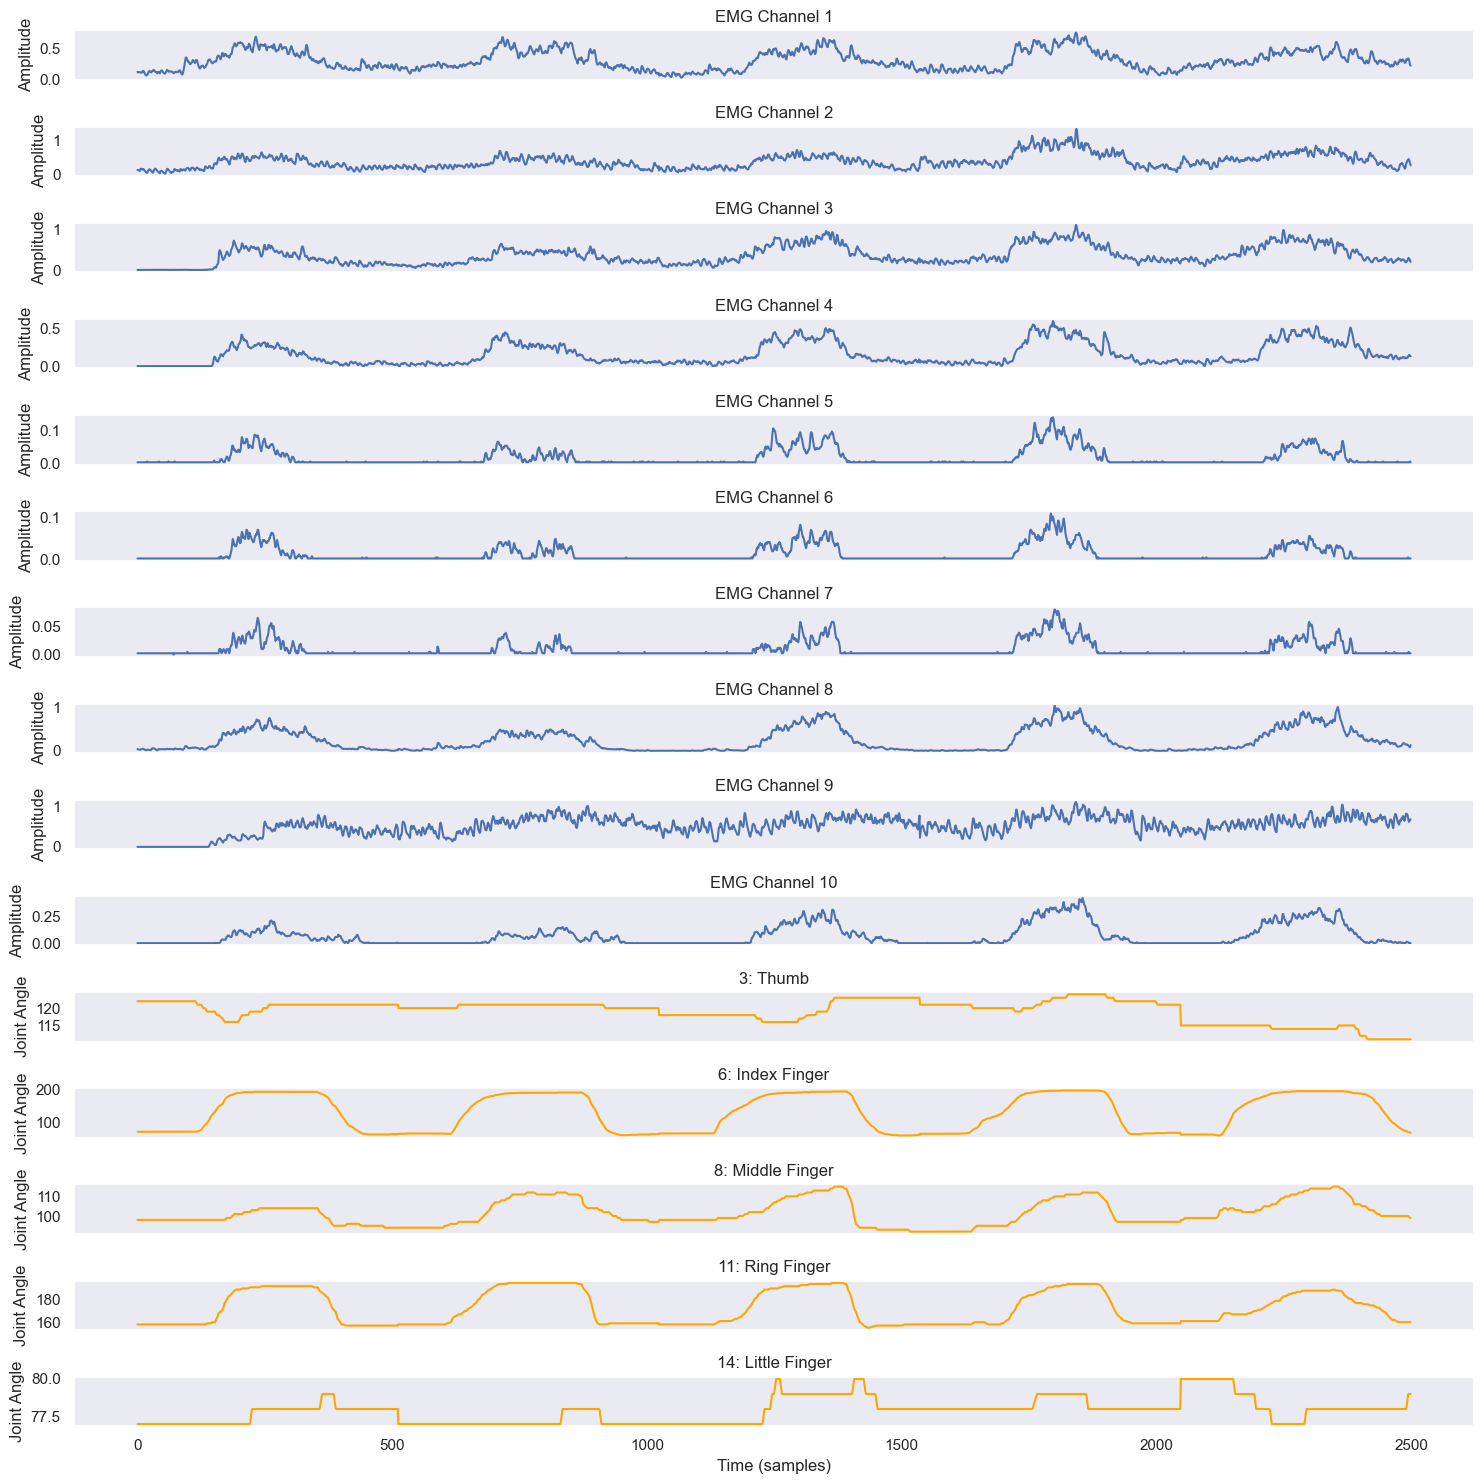

In [9]:
# Updated joint names
joint_names = ["3: Thumb", "6: Index Finger", "8: Middle Finger", "11: Ring Finger", "14: Little Finger"]

# Number of EMG channels
num_emg_channels = emg_data.shape[1]

# Create subplots: EMG channels + Joint angles
fig, axes = plt.subplots(num_emg_channels + len(joint_names), 1, figsize=(15, 15), sharex=True)

# Plot EMG signals
for i in range(num_emg_channels):
    axes[i].plot(EMG_data_train[0:2500, i], label=f"EMG Channel {i+1}")
    axes[i].set_title(f"EMG Channel {i+1}")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid()

# Plot joint angles
for i, joint_name in enumerate(joint_names):
    axes[num_emg_channels + i].plot(Labels_data_train[0:2500, i], label=joint_name, color="orange")
    axes[num_emg_channels + i].set_title(joint_name)
    axes[num_emg_channels + i].set_ylabel("Joint Angle")
    axes[num_emg_channels + i].grid()

# Set x-axis label for the last subplot
axes[-1].set_xlabel("Time (samples)")

# Adjust layout
plt.tight_layout()
plt.show()

### EMG Envelope

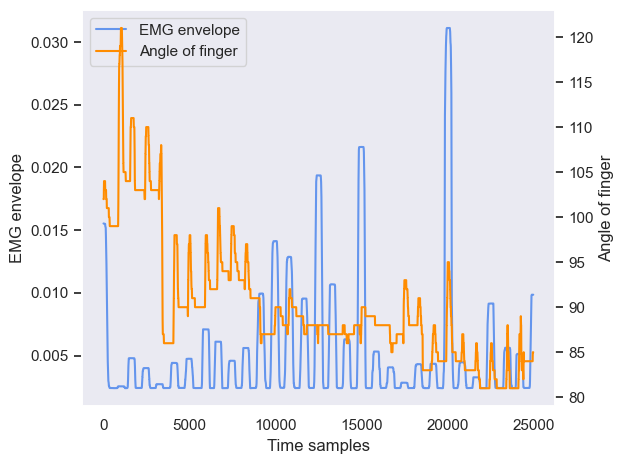

In [10]:
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes = convolve1d(emg_data, weights=mov_mean_weights, axis=0)

fig, ax = plt.subplots()
ax.plot(EMG_envelopes[75000:100000, 5],color = 'cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

finger_angle_ax = ax.twinx()
finger_angle_ax.plot(glove_data_index[75000:100000, 4], color="darkorange", label="Angle of finger")
finger_angle_ax.set_ylabel("Angle of finger")
finger_angle_ax.grid(False)

# Get handles and labels for legend
emg_handles, emg_labels = ax.get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

# Combine handles and labels
combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

# Create a single legend
ax.legend(combined_handles, combined_labels, loc='upper left')
plt.tight_layout()

### Split data

In [11]:
# Filter data by repetitions
train_reps = [1, 2, 3, 4, 7, 8, 9, 10]
test_reps = [5, 6]

# Create masks for train and test based on the repetition column
train_mask = np.isin(repetition, train_reps).flatten()
test_mask = np.isin(repetition, test_reps).flatten()

# Split the data based on the masks
EMG_train_envelopes = EMG_envelopes[train_mask]
Labels_train_envelopes = glove_data_index[train_mask]
EMG_test_envelopes = EMG_envelopes[test_mask]
Labels_test_envelopes = glove_data_index[test_mask]

# Print dataset shapes
print(f"EMG train data shape: {EMG_train_envelopes.shape}, Train label shape: {Labels_train_envelopes.shape}")
print(f"EMG test data shape: {EMG_test_envelopes.shape}, Test label shape: {Labels_test_envelopes.shape}")

EMG train data shape: (49485, 10), Train label shape: (49485, 5)
EMG test data shape: (12359, 10), Test label shape: (12359, 5)


## 2. Sliding window

In [12]:
fs = 2000  # [Hz], from dataset description
emg_window_length_sec = 0.1  # [s]
incremental_window_length_sec = 0.01  # [s]

In [13]:
# Extract overlapping time windows from the entire dataset
EMG_train_windows, Labels_train_windows = extract_time_windows_regression(EMG_train_envelopes, Labels_train_envelopes, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_test_windows, Labels_test_windows = extract_time_windows_regression(EMG_test_envelopes, Labels_test_envelopes, fs, emg_window_length_sec, incremental_window_length_sec)

# Print the shape of the extracted windows
print(f"EMG train windows shape: {EMG_train_windows.shape}, Train label windows shape: {Labels_train_windows.shape}")
print(f"EMG test windows shape: {EMG_test_windows.shape}, Test label windows shape: {Labels_test_windows.shape}")

EMG train windows shape: (2465, 200, 10), Train label windows shape: (2465, 200, 5)
EMG test windows shape: (608, 200, 10), Test label windows shape: (608, 200, 5)


## 3. Features extraction

Extract a set of features, normalize them and visualize the correlation between them.
What do you observe?

In [14]:
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows,Labels_train_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows,Labels_test_windows)

print("EMG train extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG test extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

EMG train extracted features shape: (2465, 50), Fingler labels feature shape:(2465, 5)
EMG test extracted features shape: (608, 50), Fingler labels feature shape:(608, 5)


Visualization for the training set

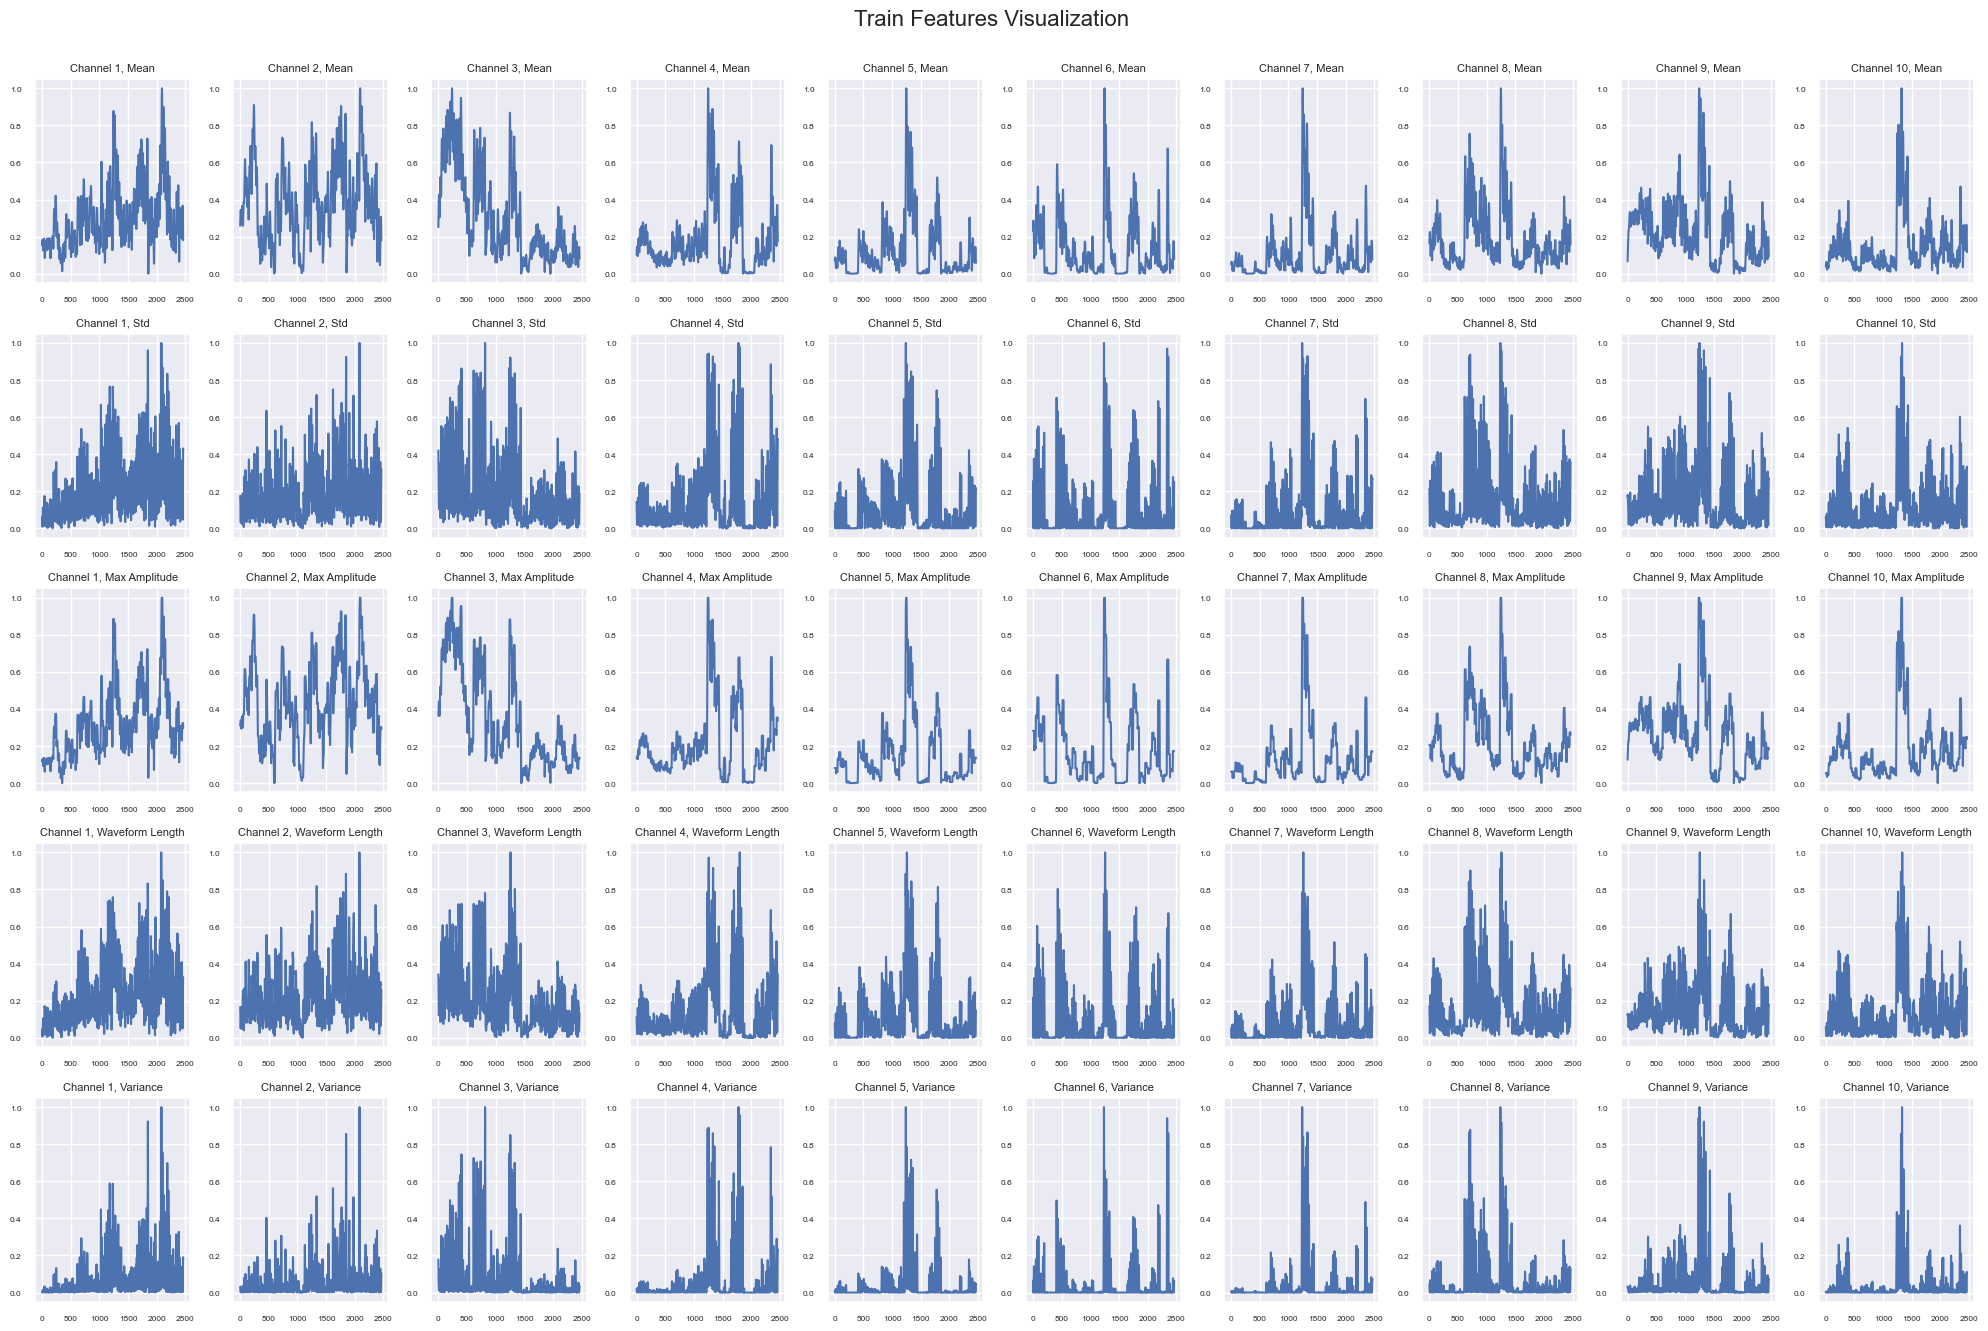

In [15]:
feature_names = [
    "Mean", 
    "Std", 
    "Max Amplitude", 
    "Waveform Length", 
    "Variance"
]

# Plot train features
plot_features(EMG_train_extracted_features, feature_names, "Train")

correlation matrix for the first channels between all the 5 features extracted

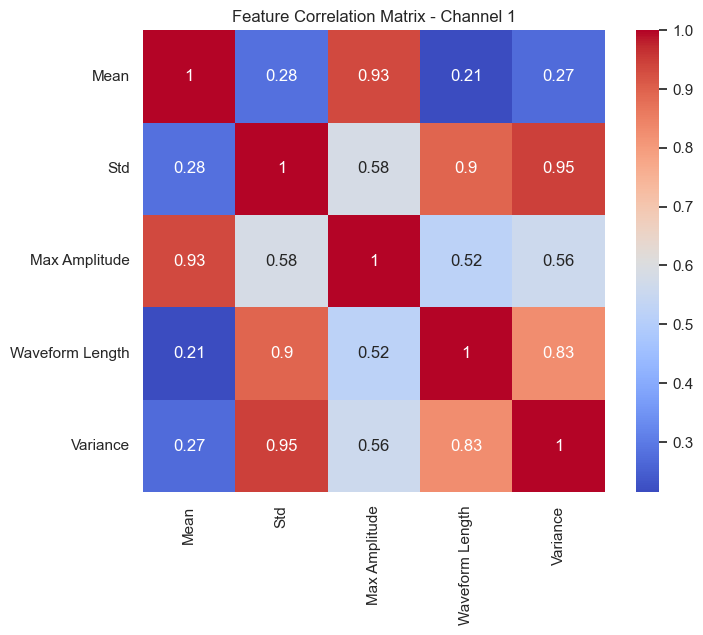

In [16]:
# Create a DataFrame for the first channel's features
channel_1_indices = [0, 10, 20, 30, 40]
channel_1_features = EMG_train_extracted_features[:, channel_1_indices]
features_df = pd.DataFrame(channel_1_features, columns=feature_names)

# Compute the correlation matrix
correlation_matrix = features_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=True, square=True)
plt.title("Feature Correlation Matrix - Channel 1")
plt.show()

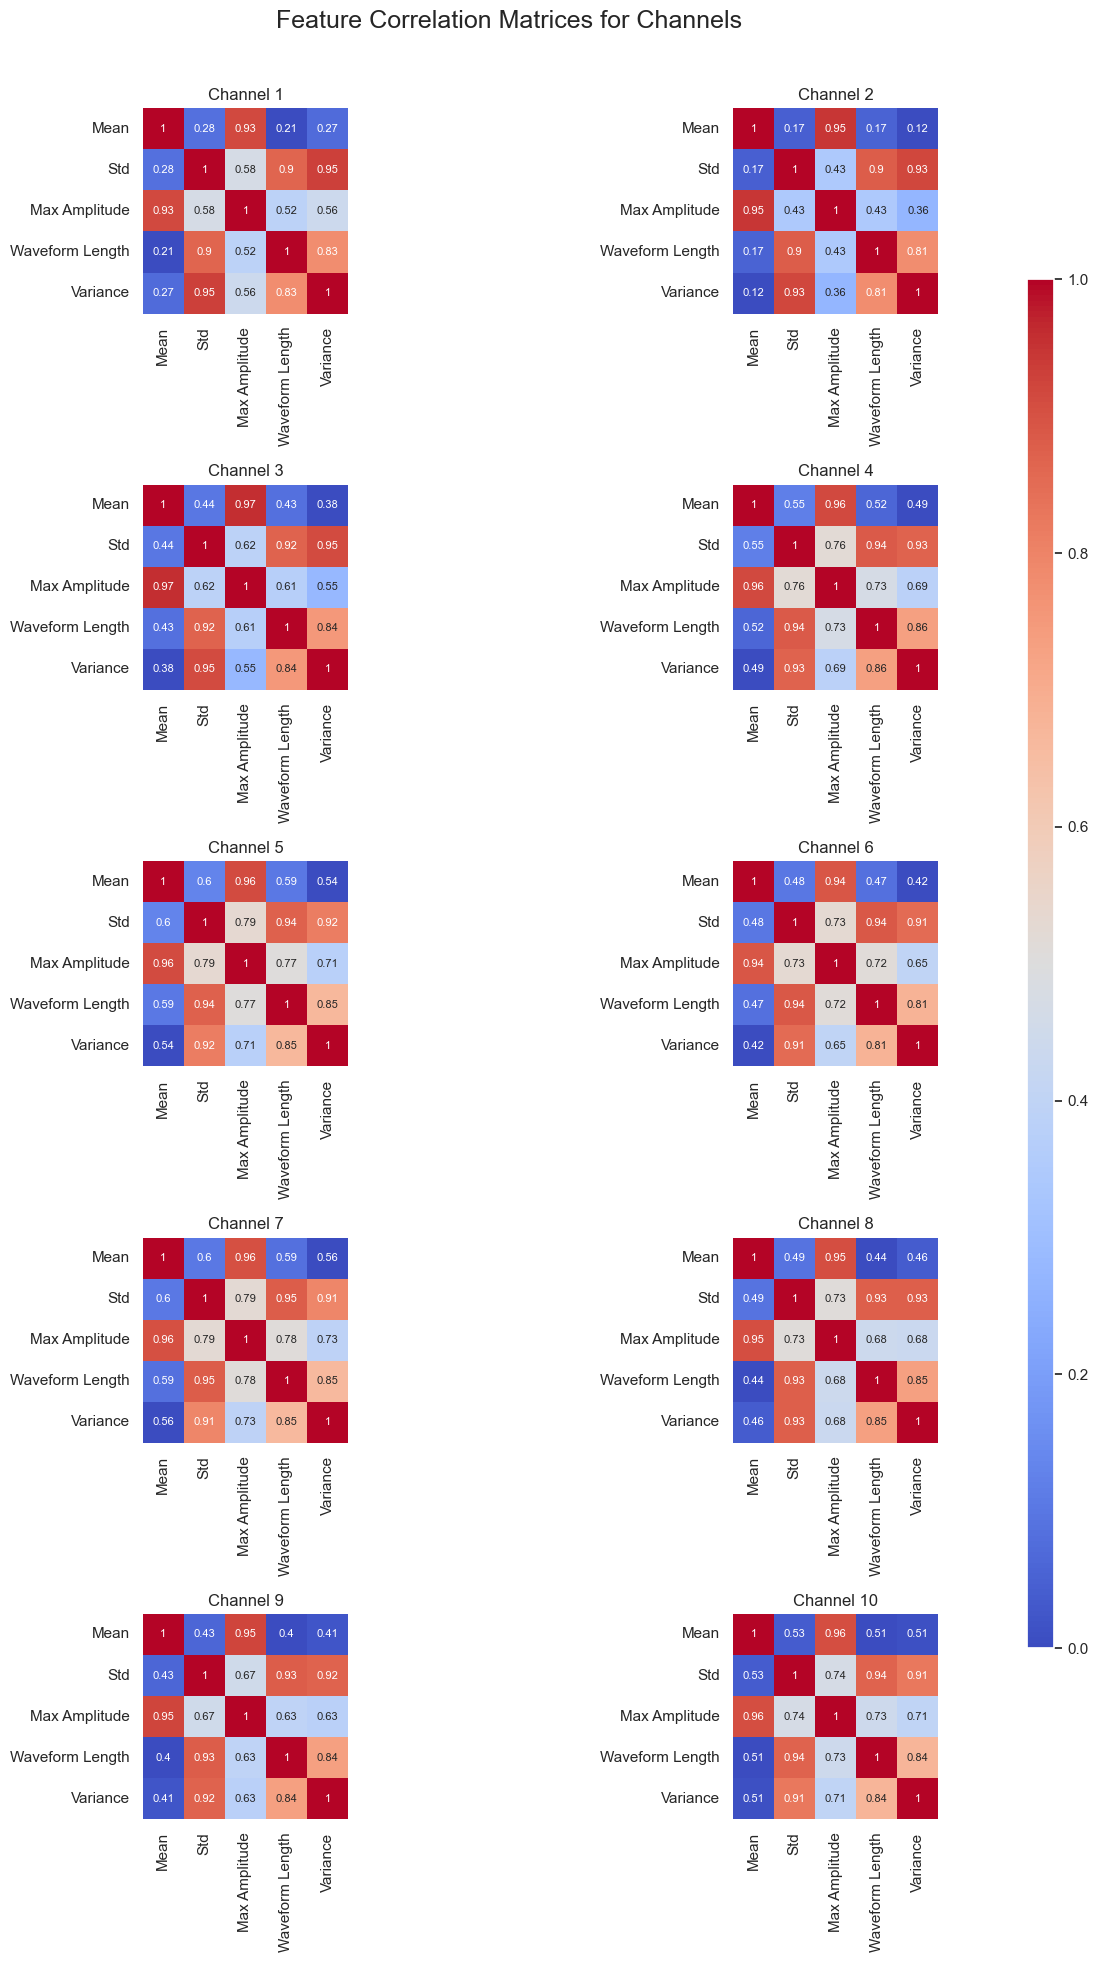

In [17]:
# Create a single figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(20, 20))  # 2 rows and 5 columns of subplots
axes = axes.ravel()  # Flatten the 2D array of axes for easier iteration

for i in range(10):
    # Select indices for the current channel
    channel_indices = [i, i+10, i+20, i+30, i+40]
    channel_features = EMG_train_extracted_features[:, channel_indices]
    features_df = pd.DataFrame(channel_features, columns=feature_names)
    
    # Compute the correlation matrix
    correlation_matrix = features_df.corr()
    
    # Visualize the correlation matrix in the corresponding subplot
    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        cmap="coolwarm", 
        cbar=False,  # Disable individual colorbars to save space
        square=True, 
        ax=axes[i],  # Specify the subplot axis
        annot_kws={"fontsize": 8},  # Font size for annotations
        xticklabels=features_df.columns, 
        yticklabels=features_df.columns
    )
    axes[i].set_title(f"Channel {i+1}")

# Adjust layout and add a single colorbar for all subplots
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust rect to make space for suptitle
fig.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=axes, location='right', aspect=50, shrink=0.8)
plt.suptitle("Feature Correlation Matrices for Channels", fontsize=18, y=0.98)
plt.show()


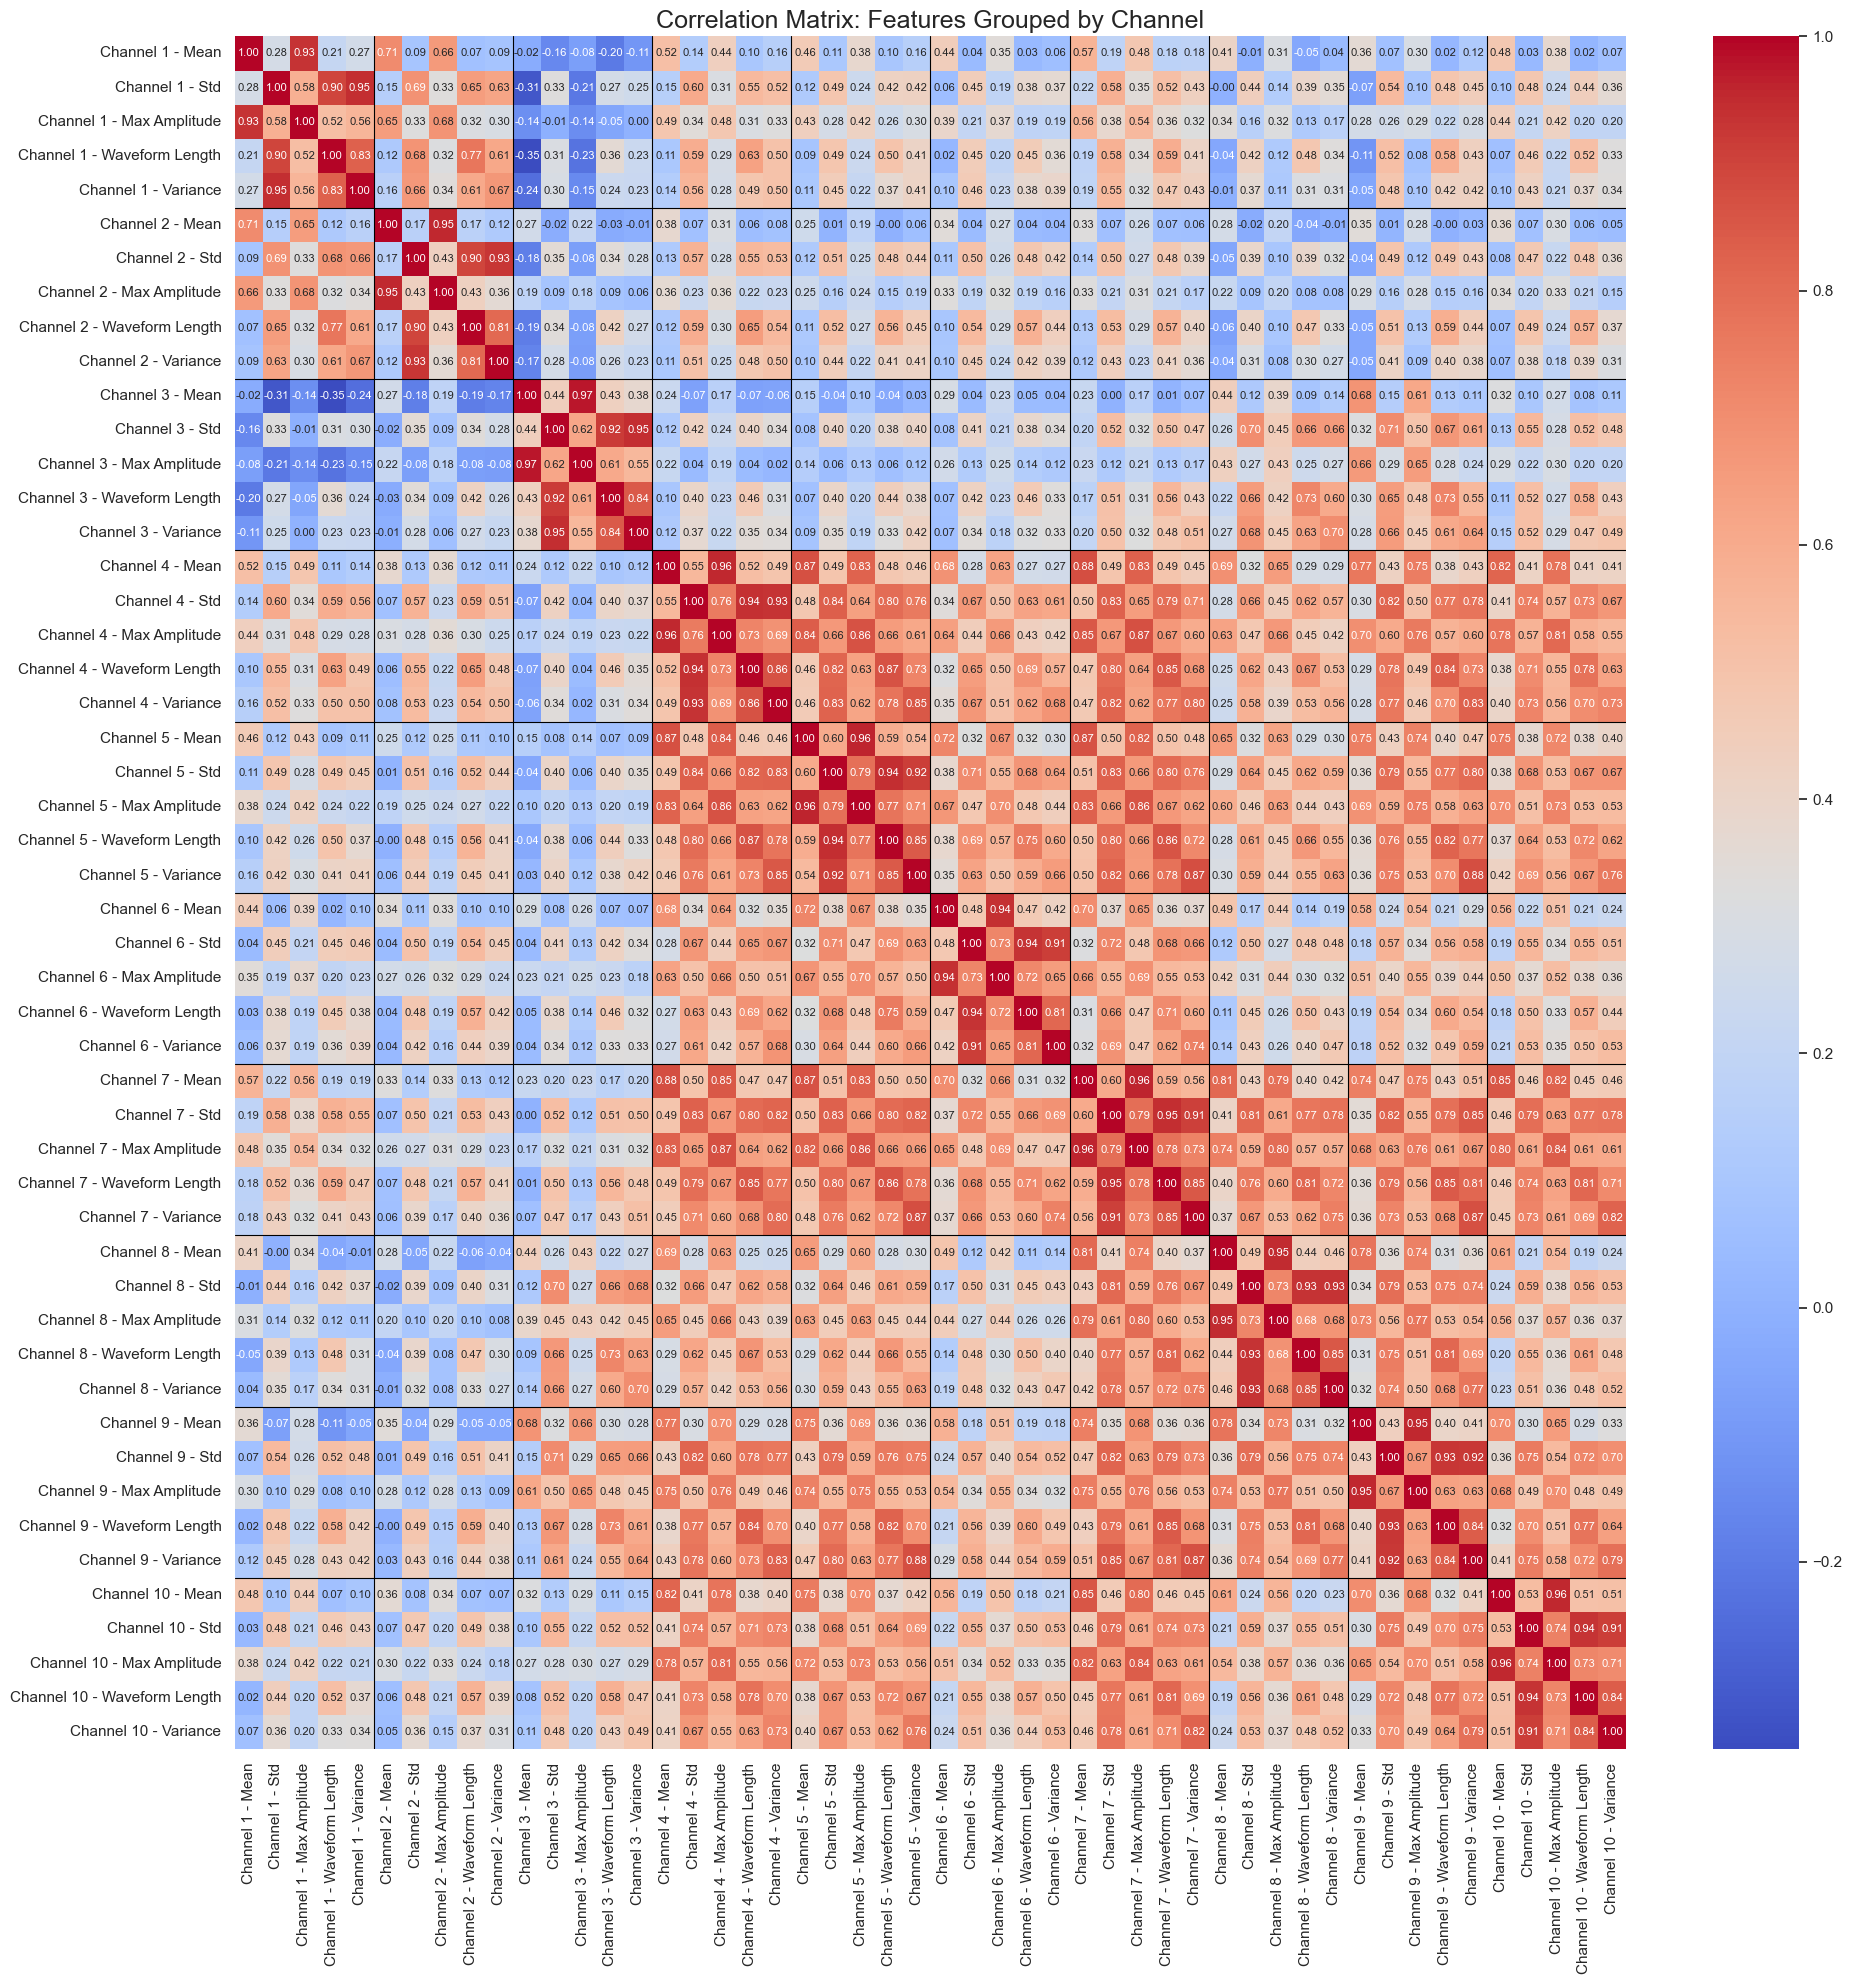

In [18]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Number of channels and features per channel
num_channels = 10
num_features_per_channel = 5

# Reshape the data to group features channel-wise
num_samples = EMG_train_extracted_features.shape[0]  # Number of rows (samples)

indices = []
for channel in range(num_channels):  # Outer loop for channels
    for feature in range(num_features_per_channel):  # Inner loop for features
        indices.append(channel + feature * num_channels)

# Create a DataFrame for readability (optional)
reordered_feature_names = [
    f"Channel {(i % num_channels) + 1} - {feature_names[j % num_features_per_channel]}"
    for j, i in enumerate(indices)
]

EMG_reordered = EMG_train_extracted_features[:, indices]

EMG_reordered_df = pd.DataFrame(EMG_reordered, columns=reordered_feature_names)

# Compute the correlation matrix
correlation_matrix = EMG_reordered_df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(20, 20))
ax = sns.heatmap(
    correlation_matrix,
    annot=True,  # Enable annotations
    fmt=".2f",  # Format for annotations
    annot_kws={"fontsize": 8},  # Smaller font size for annotations
    cmap="coolwarm",
    xticklabels=reordered_feature_names,
    yticklabels=reordered_feature_names,
    cbar=True
)

# Add lines to separate channels
for i in range(num_features_per_channel, num_channels * num_features_per_channel, num_features_per_channel):
    ax.axhline(i, color='black', linewidth=0.8)  # Horizontal line
    ax.axvline(i, color='black', linewidth=0.8)  # Vertical line

# Final touches
plt.title("Correlation Matrix: Features Grouped by Channel", fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

big confusion matrix between all the features through all the channels

## 4. Regression

Perform a regression on the kinematics (use the same family of regression method of
the previous part). Visualize and comment on the performance of the regressor.

In [19]:
#Fit and predict using the linear regression model

# Initialize the linear regression model
linear_model = LinearRegression()

# Fit the model using the training features and labels
linear_model.fit(EMG_train_extracted_features, Labels_train_mean)

# Predict on the test set
predictions = linear_model.predict(EMG_test_extracted_features)

## 5. Metrics

Evaluate the performance using a metric of your choice. Justify why the metric is
suitable for this task and whether the performance is satisfactory

In [20]:
# Compute the mean squared error
MSE = mean_squared_error(Labels_test_mean, predictions)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(Labels_test_mean, predictions)

# Print the results
print(f'MSE of Linear Regression: {MSE}')
print(f'RMSE of Linear Regression: {RMSE}')
print(f'MAE of Linear Regression: {MAE}')

MSE of Linear Regression: 241.36317718521096
RMSE of Linear Regression: 15.535867442315892
MAE of Linear Regression: 11.14496848789722


### Visualization of the predictions

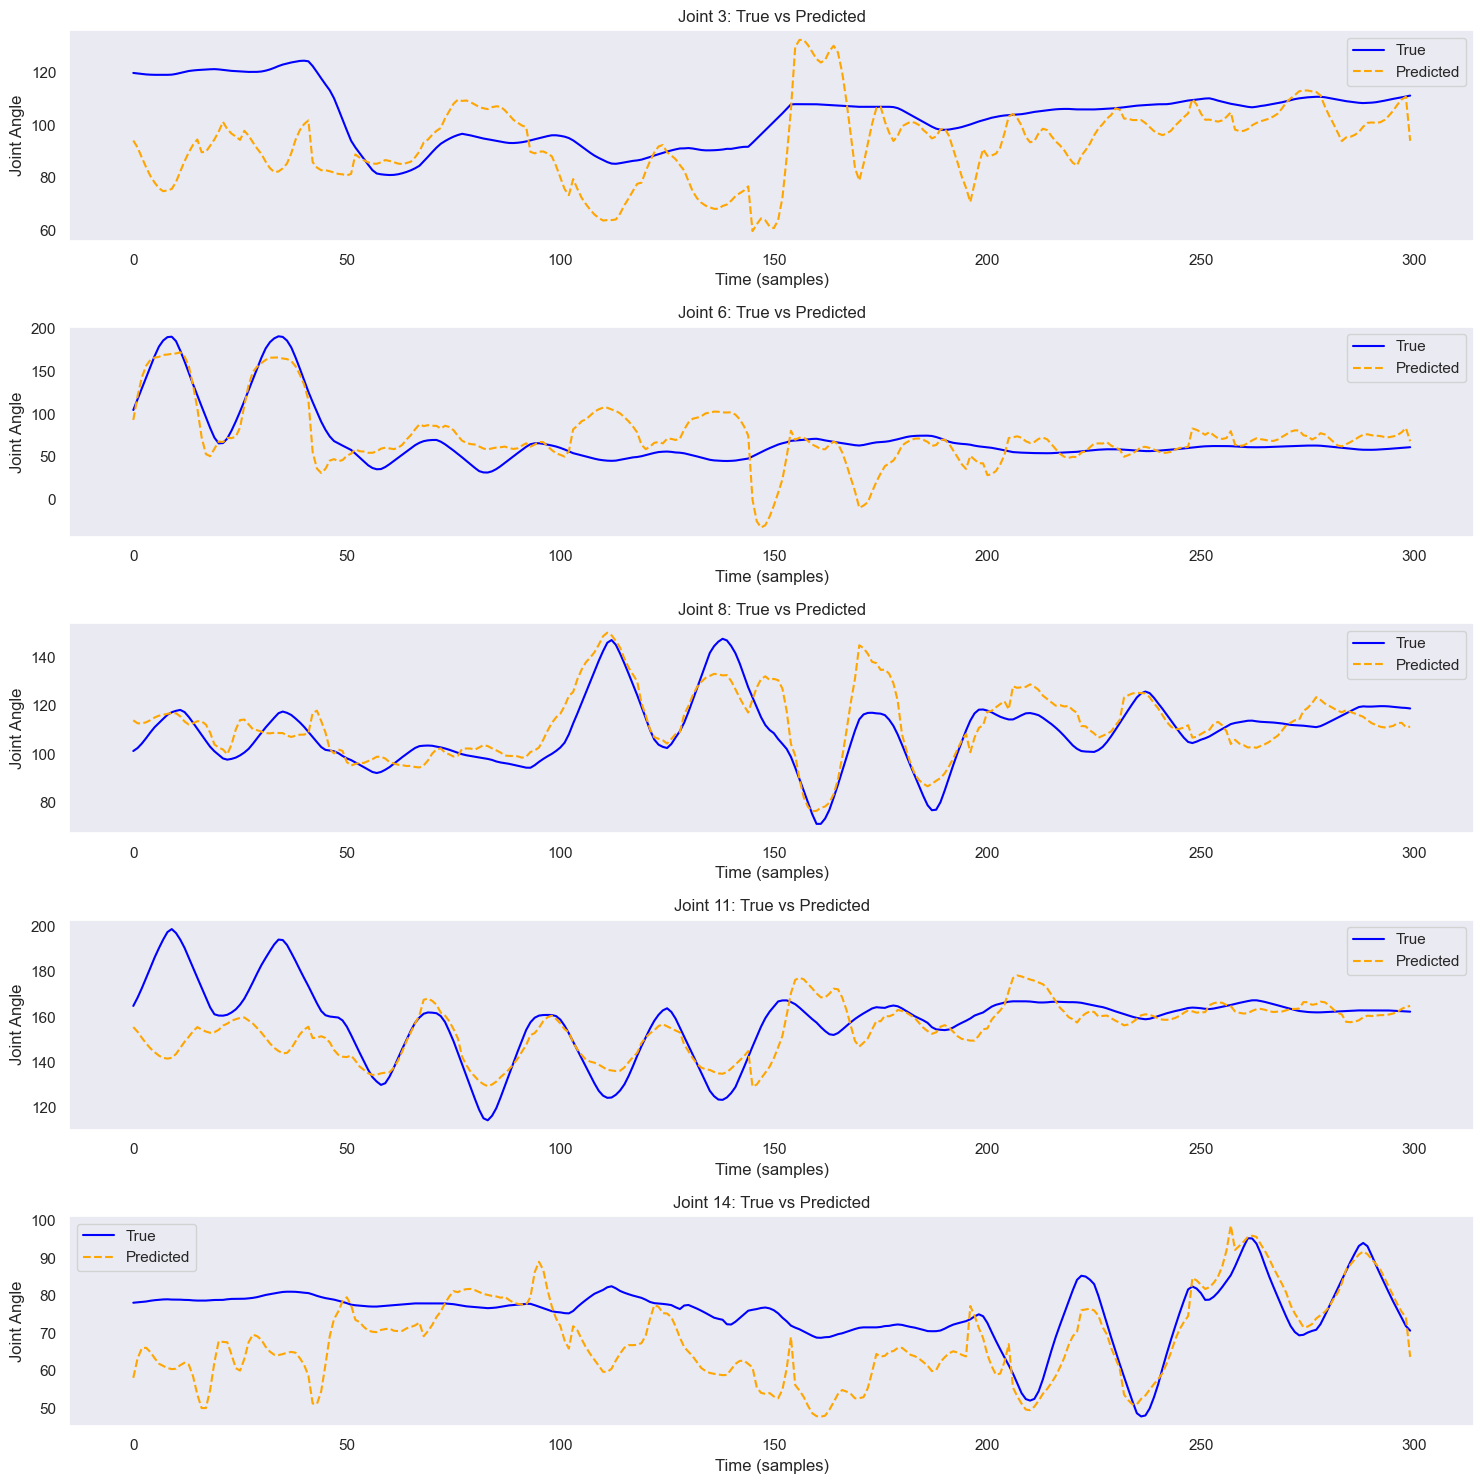

In [21]:
# Example Usage
joint_indices = [0, 1, 2, 3, 4]  # Indices for joints 3, 6, 8, 11, 14 (adjusted for 0-based indexing)
joint_names = ["3", "6", "8", "11", "14"]

plot_joint_predictions(true_values=Labels_test_mean, predictions=predictions, joint_indices=joint_indices, joint_names=joint_names)

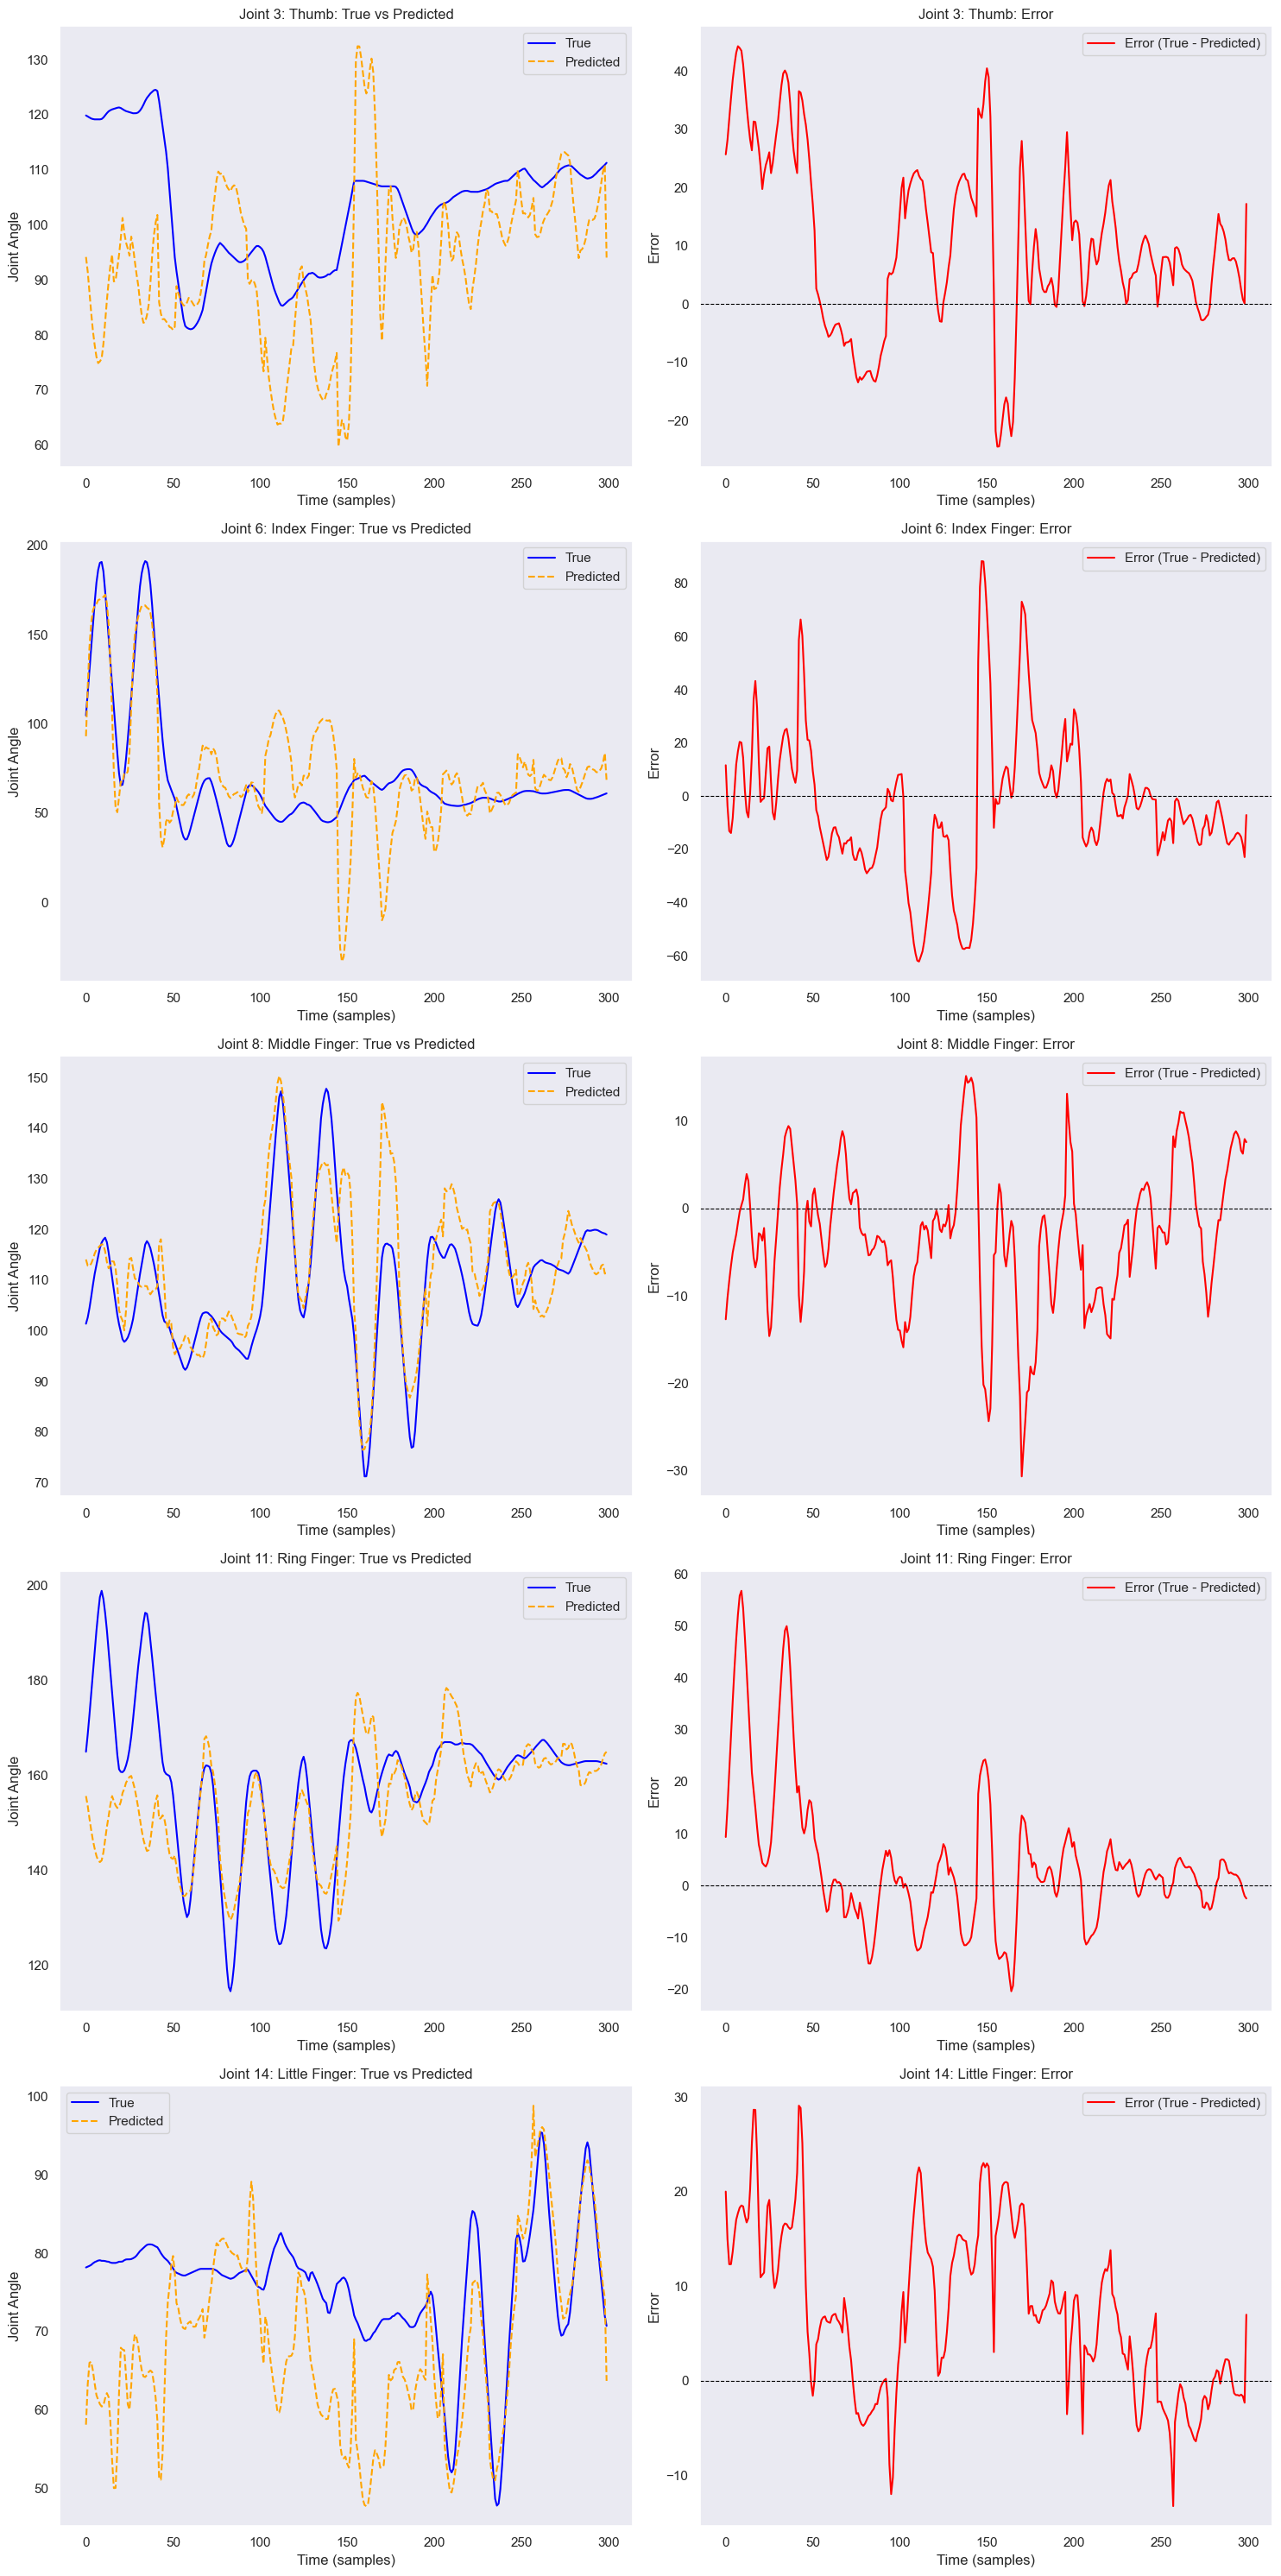

In [22]:
joint_indices = [0, 1, 2, 3, 4]  # Indices for joints 3, 6, 8, 11, 14 (adjusted for 0-based indexing)
joint_names = ["3: Thumb", "6: Index Finger", "8: Middle Finger", "11: Ring Finger", "14: Little Finger"]

plot_joint_predictions_with_error(
    true_values=Labels_test_mean, 
    predictions=predictions, 
    joint_indices=joint_indices, 
    joint_names=joint_names
)

In [23]:
# Number of joints (fingers)
num_joints = Labels_test_mean.shape[1]

# Initialize dictionaries to store metrics for each joint
mse_per_joint = {}
rmse_per_joint = {}
mae_per_joint = {}

# Compute metrics for each joint
for joint_idx in range(num_joints):
    true_values = Labels_test_mean[:, joint_idx]
    predicted_values = predictions[:, joint_idx]
    
    mse_per_joint[f"Joint {joint_idx + 1}"] = mean_squared_error(true_values, predicted_values)
    rmse_per_joint[f"Joint {joint_idx + 1}"] = np.sqrt(mse_per_joint[f"Joint {joint_idx + 1}"])
    mae_per_joint[f"Joint {joint_idx + 1}"] = mean_absolute_error(true_values, predicted_values)

# Print the results for each joint
print("Metrics per Joint:")
i=0
for joint_name in mse_per_joint.keys():
    print(f"joint {joint_names[i]} -> MSE: {mse_per_joint[joint_name]:.4f}, RMSE: {rmse_per_joint[joint_name]:.4f}, MAE: {mae_per_joint[joint_name]:.4f}")
    i+=1

Metrics per Joint:
joint 3: Thumb -> MSE: 254.6443, RMSE: 15.9576, MAE: 12.1701
joint 6: Index Finger -> MSE: 513.4011, RMSE: 22.6584, MAE: 16.8579
joint 8: Middle Finger -> MSE: 184.4988, RMSE: 13.5830, MAE: 10.7458
joint 11: Ring Finger -> MSE: 122.2716, RMSE: 11.0576, MAE: 7.0841
joint 14: Little Finger -> MSE: 132.0001, RMSE: 11.4891, MAE: 8.8670


### Visualization of the RMSE of various sliding windows

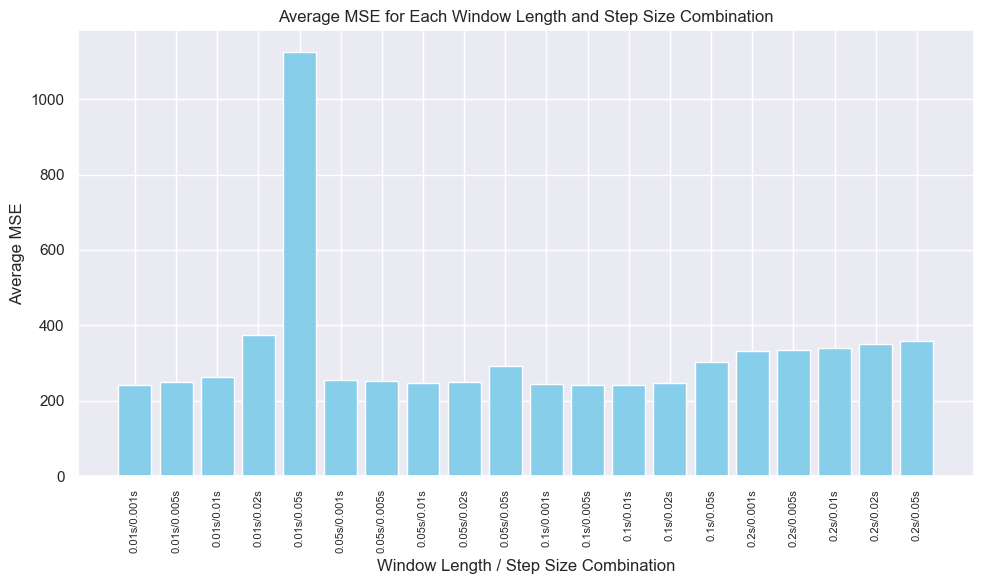

Best Configuration:
- Window Length: 0.1 seconds
- Step Size: 0.01 seconds
- Average MSE: 241.3632
Metrics per Joint:
joint 3: Thumb -> MSE: 254.6443, RMSE: 15.9576, MAE: 12.1701
joint 6: Index Finger -> MSE: 513.4011, RMSE: 22.6584, MAE: 16.8579
joint 8: Middle Finger -> MSE: 184.4988, RMSE: 13.5830, MAE: 10.7458
joint 11: Ring Finger -> MSE: 122.2716, RMSE: 11.0576, MAE: 7.0841
joint 14: Little Finger -> MSE: 132.0001, RMSE: 11.4891, MAE: 8.8670


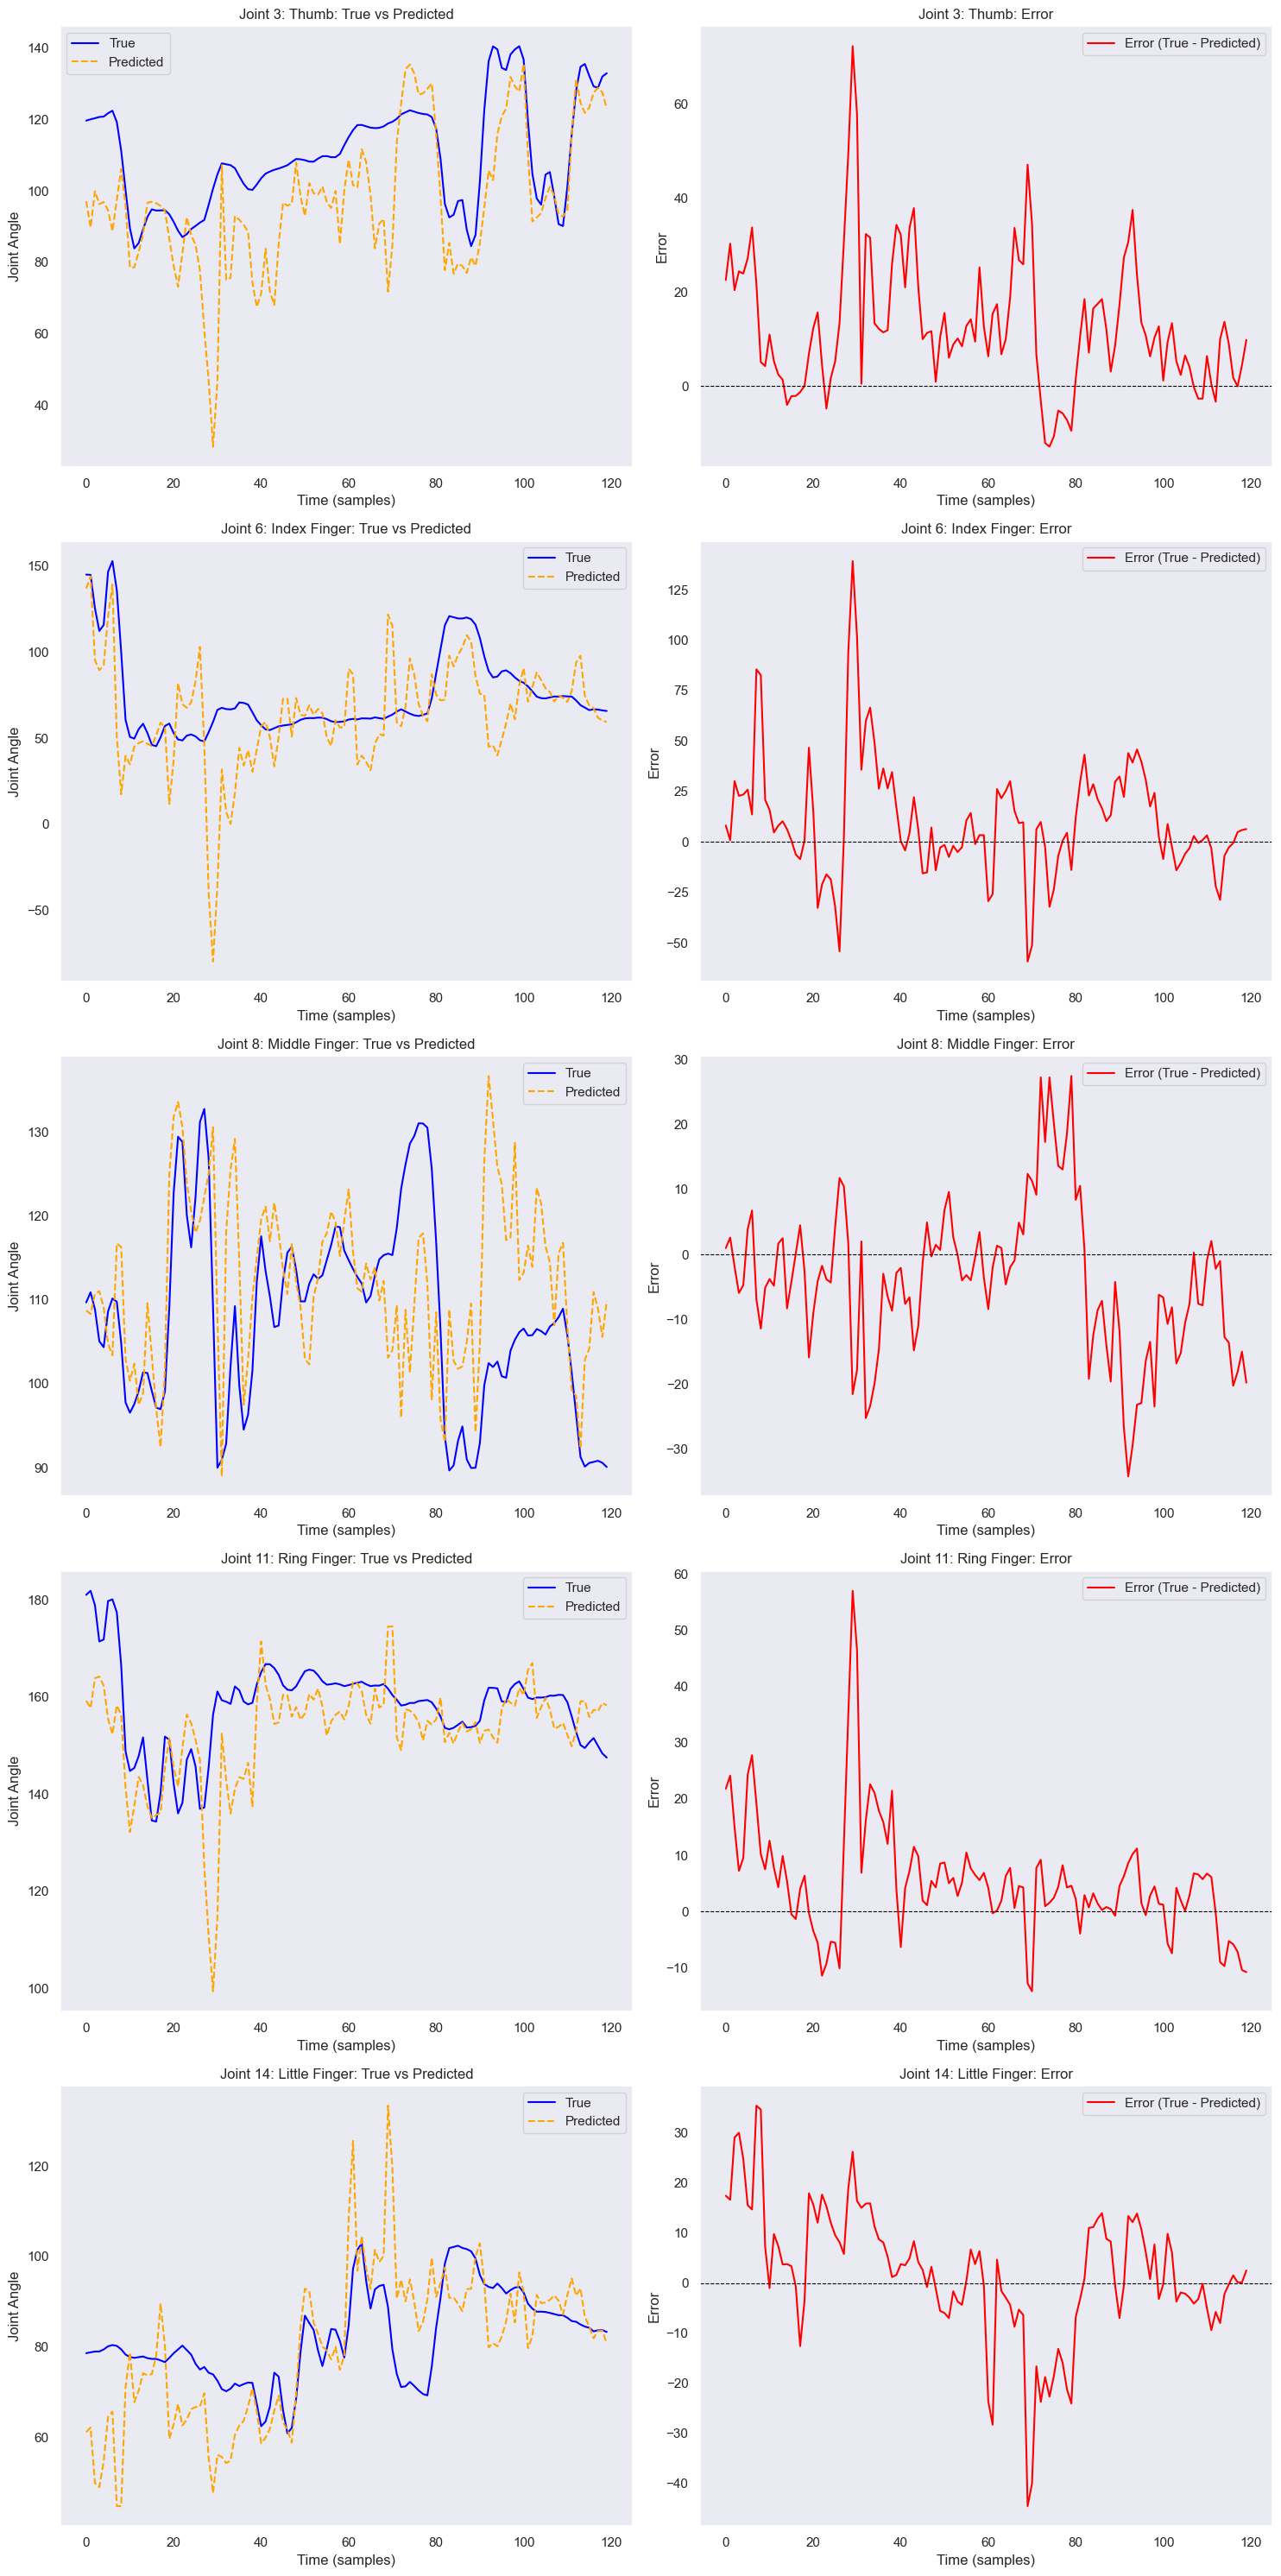

In [24]:
# Define ranges for sliding window parameters
window_lengths = [0.01, 0.05, 0.1, 0.2]  # In seconds
step_sizes = [0.001, 0.005, 0.01, 0.02, 0.05]  # In seconds

# Initialize variables to store the best configuration and its errors
best_window_length = None
best_step_size = None
best_average_mse = float('inf')
best_metrics = None

# Joint names
joint_names = ["3: Thumb", "6: Index Finger", "8: Middle Finger", "11: Ring Finger", "14: Little Finger"]

# Store metrics for all combinations
results = []

# Iterate through all combinations of window lengths and step sizes
for emg_window_length_sec in window_lengths:
    for incremental_window_length_sec in step_sizes:
        # trin/test windowa
        EMG_train_windows, Labels_train_windows = extract_time_windows_regression(EMG_train_envelopes, Labels_train_envelopes, fs, emg_window_length_sec, incremental_window_length_sec)
        EMG_test_windows, Labels_test_windows = extract_time_windows_regression(EMG_test_envelopes, Labels_test_envelopes, fs, emg_window_length_sec, incremental_window_length_sec)

        # Extract features from the windows
        EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows,Labels_train_windows)
        EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows,Labels_test_windows)

        # Initialize the linear regression model
        linear_model = LinearRegression()

        # Fit the model using the training features and labels
        linear_model.fit(EMG_train_extracted_features, Labels_train_mean)

        # Predict on the test set
        predictions = linear_model.predict(EMG_test_extracted_features)

        # Number of joints (fingers)
        num_joints = Labels_test_mean.shape[1]

        # Initialize dictionaries to store metrics for each joint
        mse_per_joint = {}
        rmse_per_joint = {}
        mae_per_joint = {}

        # Compute metrics for each joint
        for joint_idx in range(num_joints):
            true_values = Labels_test_mean[:, joint_idx]
            predicted_values = predictions[:, joint_idx]

            mse_per_joint[f"Joint {joint_idx + 1}"] = mean_squared_error(true_values, predicted_values)
            rmse_per_joint[f"Joint {joint_idx + 1}"] = np.sqrt(mse_per_joint[f"Joint {joint_idx + 1}"])
            mae_per_joint[f"Joint {joint_idx + 1}"] = mean_absolute_error(true_values, predicted_values)

        # Compute the average MSE across all joints
        average_mse = np.mean(list(mse_per_joint.values()))

        # Store the results for this combination
        results.append({
            "window_length": emg_window_length_sec,
            "step_size": incremental_window_length_sec,
            "average_mse": average_mse,
            "mse_per_joint": mse_per_joint,
            "rmse_per_joint": rmse_per_joint,
            "mae_per_joint": mae_per_joint
        })

        # Check if this configuration is the best so far
        if average_mse < best_average_mse:
            best_average_mse = average_mse
            best_window_length = emg_window_length_sec
            best_step_size = incremental_window_length_sec
            best_metrics = {
                "mse_per_joint": mse_per_joint,
                "rmse_per_joint": rmse_per_joint,
                "mae_per_joint": mae_per_joint
            }

# Plot the results
plt.figure(figsize=(10, 6))
window_step_combinations = [f"{res['window_length']}s/{res['step_size']}s" for res in results]
average_mse_values = [res['average_mse'] for res in results]

plt.bar(window_step_combinations, average_mse_values, color='skyblue')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Window Length / Step Size Combination")
plt.ylabel("Average MSE")
plt.title("Average MSE for Each Window Length and Step Size Combination")
plt.tight_layout()
plt.show()

# Print the best configuration and its metrics
print(f"Best Configuration:")
print(f"- Window Length: {best_window_length} seconds")
print(f"- Step Size: {best_step_size} seconds")
print(f"- Average MSE: {best_average_mse:.4f}")

print("Metrics per Joint:")
for joint_idx, joint_name in enumerate(joint_names):
    print(f"joint {joint_name} -> MSE: {best_metrics['mse_per_joint'][f'Joint {joint_idx + 1}']:.4f}, "
          f"RMSE: {best_metrics['rmse_per_joint'][f'Joint {joint_idx + 1}']:.4f}, "
          f"MAE: {best_metrics['mae_per_joint'][f'Joint {joint_idx + 1}']:.4f}")
    
plot_joint_predictions_with_error(
    true_values=Labels_test_mean, 
    predictions=predictions, 
    joint_indices=joint_indices, 
    joint_names=joint_names
)